Here we import the relevant libraries and raw spectrum data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np

In [2]:
#df = pd.read_csv("/home/stang/peak-detection-test/exosomes.raw_spectrum_1.csv")
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Grid Detection

In [3]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal


### Find Peaks

We use the find peaks method from scipy to get peaks from our spectral data. We found through trial and error that a peak prominence of 75 give an appropriate amount of peaks for each sample.

In [4]:
# This makes sure to find the peaks of each sample independently.

peaks = []

for _, group in df.groupby('SpecID'):
    peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)
    peaks += list(group.iloc[peak_index].index.values)

In [5]:
print(len(peaks))

93512


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

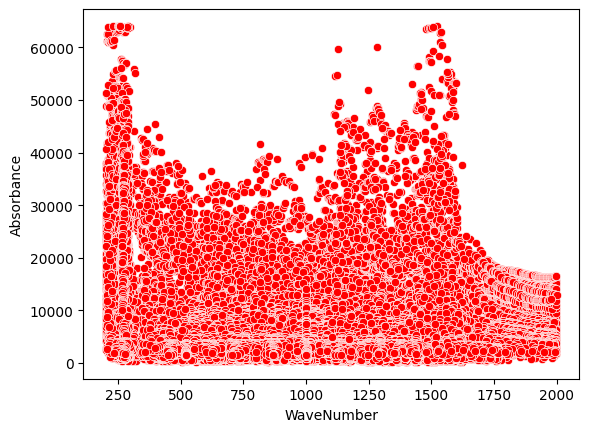

In [6]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", color="red")

As can be seen in the above graph, there is a huge variation of where peaks can be found. Below, we then attach the peak information to our dataframe

In [7]:
peak_df = df.iloc[peaks]

In [8]:
peak_df.head(5)

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
613,201210-1-00,613,618.90662,1842.5710,201210-1,Normal
727,201210-1-00,727,696.81091,1851.9185,201210-1,Normal
1026,201210-1-00,1026,901.13898,1746.4041,201210-1,Normal
1165,201210-1-00,1165,996.12756,1702.7238,201210-1,Normal
1244,201210-1-00,1244,1050.11390,1674.6296,201210-1,Normal


Below is a funtion that will take a peak's co-ordinates (Wavenumber and Absorbance) and output a grid number. Based on what grid square each peak is in, we should be able to combine strings of peaks together to get an interconnected graph.

### Create Peak Grid

In [9]:
# Lets looks at the dataset before defining the grid

print(max(df['Absorbance']))
print(max(df['WaveNumber']))

64076.531
2000.0


This function assigns each peak to a grid based on their Wavenumber and Absorbance

In [10]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [11]:
peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], 2, 10), axis=1)

/tmp/ipykernel_5128/4155505224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], 2, 10), axis=1)


Show the number of unique grid locations found.

In [12]:
peak_df['GridSlot'].nunique()

86723

In [13]:
peak_df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,GridSlot
613,201210-1-00,613,618.90662,1842.5710,201210-1,Normal,"(309, 184)"
727,201210-1-00,727,696.81091,1851.9185,201210-1,Normal,"(348, 185)"
1026,201210-1-00,1026,901.13898,1746.4041,201210-1,Normal,"(450, 174)"
1165,201210-1-00,1165,996.12756,1702.7238,201210-1,Normal,"(498, 170)"
1244,201210-1-00,1244,1050.11390,1674.6296,201210-1,Normal,"(525, 167)"


### Create the graph structure

We need the indices as values.

In [14]:
peak_df['Node_ID'] = peak_df.index

/tmp/ipykernel_5128/412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [15]:
peak_df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,GridSlot,Node_ID
613,201210-1-00,613,618.90662,1842.5710,201210-1,Normal,"(309, 184)",613
727,201210-1-00,727,696.81091,1851.9185,201210-1,Normal,"(348, 185)",727
1026,201210-1-00,1026,901.13898,1746.4041,201210-1,Normal,"(450, 174)",1026
1165,201210-1-00,1165,996.12756,1702.7238,201210-1,Normal,"(498, 170)",1165
1244,201210-1-00,1244,1050.11390,1674.6296,201210-1,Normal,"(525, 167)",1244


In [16]:
peak_df = peak_df.drop(columns=['Seq', 'WaveNumber', 'Absorbance', 'SurID'])

We want all peaks from the same sample to connect to each other.

In [17]:
same_sample = pd.merge(peak_df, peak_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))

In [18]:
len(same_sample)

5921544

In [19]:
same_sample.head()

,SpecID,Status,GridSlot,Node_ID_src,Node_ID_dst
0,201210-1-00,Normal,"(309, 184)",613,613
1,201210-1-00,Normal,"(309, 184)",613,727
2,201210-1-00,Normal,"(309, 184)",613,1026
3,201210-1-00,Normal,"(309, 184)",613,1165
4,201210-1-00,Normal,"(309, 184)",613,1244


Then we want all peaks in the same grid slot to connect to each other along with peaks in adacent grid slots.

In [20]:
same_grid_slot = pd.merge(peak_df, peak_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))

In [21]:
same_grid_slot.head()

,SpecID,Status,GridSlot,Node_ID_src,Node_ID_dst
0,201210-1-00,Normal,"(309, 184)",613,613
1,201210-1-00,Normal,"(309, 184)",613,1449862
2,210217-2-01,Hyperglycemia,"(309, 184)",1449862,613
3,210217-2-01,Hyperglycemia,"(309, 184)",1449862,1449862
4,201210-1-00,Normal,"(348, 185)",727,727


In [22]:
len(same_grid_slot)

109596

Combine the two dataframes

In [23]:
graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

Free up some memory by deleting the intermediate dataframes.

In [24]:
del same_sample
del same_grid_slot

In [25]:
len(graph_df)

6031140

In [26]:
graph_df.head()

,SpecID,Status,GridSlot,Node_ID_src,Node_ID_dst
0,201210-1-00,Normal,"(309, 184)",613,613
1,201210-1-00,Normal,"(309, 184)",613,727
2,201210-1-00,Normal,"(309, 184)",613,1026
3,201210-1-00,Normal,"(309, 184)",613,1165
4,201210-1-00,Normal,"(309, 184)",613,1244


Clean up the graph dataframe

In [27]:
graph_df = graph_df.drop(columns=['SpecID', 'GridSlot'])

In [28]:
graph_df.head()

,Status,Node_ID_src,Node_ID_dst
0,Normal,613,613
1,Normal,613,727
2,Normal,613,1026
3,Normal,613,1165
4,Normal,613,1244


Remove relationships where nodes connect to themselves.

In [29]:
graph_df = graph_df[graph_df['Node_ID_src'] != graph_df['Node_ID_dst']]

In [30]:
len(graph_df)

5844116

#### Create the nodes file.

In [31]:
nodes = graph_df[['Node_ID_src', 'Status']].drop_duplicates()

In [32]:
nodes.head()

,Node_ID_src,Status
1,613,Normal
7,727,Normal
14,1026,Normal
21,1165,Normal
28,1244,Normal


Use the headers needed by neo4j admin import.

In [33]:
nodes = nodes.rename(columns={'Node_ID_src': "Node_ID:ID"})

In [34]:
nodes[':LABEL'] = "Peak"

In [35]:
nodes

,Node_ID:ID,Status,:LABEL
1,613,Normal,Peak
7,727,Normal,Peak
14,1026,Normal,Peak
21,1165,Normal,Peak
28,1244,Normal,Peak
...,...,...,...
6009558,6098917,Normal,Peak
6009575,5081812,Normal,Peak
6009576,5969807,Normal,Peak
6011140,6004055,Normal,Peak


In [36]:
nodes.to_csv("../../data/peak_nodes.csv", index=False)

#### Create the relationships file.

In [37]:
graph_df.head()

,Status,Node_ID_src,Node_ID_dst
1,Normal,613,727
2,Normal,613,1026
3,Normal,613,1165
4,Normal,613,1244
5,Normal,613,1553


As the relationships will be bidirectional we want to remove redundant relationships e.g we only want one of (613, 727) (727,613).

To do this the relationships are sorted across the rows and then duplicates are removed.

In [38]:
graph_df[['Node_ID_src', 'Node_ID_dst']] = np.sort(graph_df[['Node_ID_src', 'Node_ID_dst']])

In [39]:
graph_df = graph_df.drop_duplicates()

In [40]:
graph_df = graph_df[['Node_ID_src', 'Node_ID_dst']]

In [41]:
graph_df = graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})

In [42]:
graph_df.head()

,:START_ID,:END_ID
1,613,727
2,613,1026
3,613,1165
4,613,1244
5,613,1553


In [43]:
graph_df

,:START_ID,:END_ID
1,613,727
2,613,1026
3,613,1165
4,613,1244
5,613,1553
...,...,...
6030546,7895827,7940624
6030564,7924186,7966348
6030601,7954449,8012419
6030628,7983219,8014839


In [44]:
graph_df.to_csv("../../data/peak_edges.csv", index=False)